# IMU noise characterization

Three different approaches;
- historgram
- custom Allan deviation
- using allan tools

Familiarity with the IEEE Standard 952 as well as with the nomenclature commonly used, the various units, etc, is helpful.

References

- mixture of gaussian:
https://stackoverflow.com/questions/35990467/fit-mixture-of-two-gaussian-normal-distributions-to-a-histogram-from-one-set-of

Few notes:
Histogram
This method uses numpy.histogram to bin the data in x and count the number of values in each bin, then draws the distribution either as a BarContainer or Polygon. The bins, range, density, and weights parameters are forwarded to numpy.histogram.
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist

In [1]:
%matplotlib inline
# plot the gyroscope historgram for few seconds of data
# https://stackoverflow.com/questions/29208440/fit-a-distribution-to-a-histogram
# https://stackoverflow.com/questions/70164620/how-to-gaussian-fit-histogram
# For gyro input in rad/s, the FWHM will be in rad/s
# TODO find relation between sigma and FWHM
import os # for file manipulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal
import scipy.stats as stats

HOME = os.getenv("HOME")
PATH2FILE = HOME + '/Data/Drones/IMU/'

# MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_90mn_SR200_Static_yUp' 
# MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_30mn_SR200_motorOn_29042024' 
# MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_60mn_SR200_motorOn_03052024' 
# MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_2mn_SR200_CartRolling_yUp'
MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_2mn_SR200_FlightManual_yUp'
# old name: 'OAKLight_BMI270_90mn_gyroSR250_accSR250_yUp'
CSV_FILENAME = PATH2FILE + MEAS_FILENAME_NO_EXT + '.csv' 
# some string manip
split_btwn__ = MEAS_FILENAME_NO_EXT.split('_')
CAM_NAME = split_btwn__[0]
IMU_NAME = split_btwn__[1]
MEAS_DURATION = split_btwn__[3]
IMU_ORIENTATION = split_btwn__[-1]
TEST_CONFIG = split_btwn__[-2] # how the test was conducted (in flight, static....)

# get the sampling rate from file name
try:
    sr = MEAS_FILENAME_NO_EXT.split('SR')[1]
    sr = (float)(sr.split('_')[0])
    FS = sr
    print(f'got the sampling rate from filename, FS = {FS}')
except:    
    FS = 200 # Sample rate [Hz] # this is obtained from the measured data
    print(f'This is the sampling rate: FS = {FS}\n Make sure it is correct!')

FIG_FILENAME_BASE = IMU_NAME + '_' + TEST_CONFIG
SAVE_FIG = True
FIG_FMT = 'svg'
NOISE_PARAM_UNIT = 'rad'
ANGLE_UNIT_FOR_NOISE = 'rad' # or 'deg'
VELOCITY_UNIT_FOR_NOISE = 'm/s' # or e.g. 'cm/s'
ACCELERATION_UNIT_FOR_NOISE = 'm/s²' # or 'ug'
ACCELERATION_UNIT = 'm/s²' # or 'g'
# printings and formatting, conversion factors
# m/s² to μg
MS2_TO_MICROG = 1e6 / 9.81
PRECI= 2
TYPE = "e" # e: exponential notation
TS = 1.0 / FS
# NB_SAMPLE = 1000 # nb of samples to take from the input data (csv file) for the historgram
NB_SAMPLE = 24000 # 24000 is 2mn of data at 200Hz

DEG_2_RAD = np.pi / 180.0
RAD_2_DEG = 180.0 / np.pi
NBINS = 30 # number of bins for the histogram
# LOAD_SAMPLE = 'all'
LOAD_SAMPLE = 'start'

got the sampling rate from filename, FS = 200.0


The angular rate sensor is described by the quantities $N$ (angle random walk), $B$ (bias instability) and $K$ (rate random walk) from the IEEE Std 952. The values prescribed here approximate the properties of a Bosch SMI130 yaw rate sensor.

In [2]:
# functions
# for FHWM
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)
def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

In [3]:
# Load CSV into np array (take few seconds so put in a separate cell)
dataArr = np.genfromtxt(CSV_FILENAME, delimiter=',')

In [4]:
# Separate into arrays and select a slice of the input data
if LOAD_SAMPLE == 'all':
    acc_ts = dataArr[:, 0]  # time stamp for acceleration, second
    accx = dataArr[:, 1]  # m/s²
    accy = dataArr[:, 2]
    accz = dataArr[:, 3]
    ts = dataArr[:, 4]  # time stamp, second
    gx = dataArr[:, 5]  # (rad/s)
    gy = dataArr[:, 6]
    gz = dataArr[:, 7]
elif LOAD_SAMPLE == 'start':
    acc_ts = dataArr[:NB_SAMPLE, 0]  # time stamp for acceleration, second
    accx = dataArr[:NB_SAMPLE, 1]  # m/s²
    accy = dataArr[:NB_SAMPLE, 2]
    accz = dataArr[:NB_SAMPLE, 3]
    ts = dataArr[:NB_SAMPLE, 4]  # time stamp, second
    gx = dataArr[:NB_SAMPLE, 5]  # (rad/s)
    gy = dataArr[:NB_SAMPLE, 6]
    gz = dataArr[:NB_SAMPLE, 7]
elif LOAD_SAMPLE == 'end':
    acc_ts = dataArr[-NB_SAMPLE:, 0]  # time stamp for acceleration, second
    accx = dataArr[-NB_SAMPLE:, 1]  # m/s²
    accy = dataArr[-NB_SAMPLE:, 2]
    accz = dataArr[-NB_SAMPLE:, 3]
    ts = dataArr[-NB_SAMPLE:, 4]  # time stamp, second
    gx = dataArr[-NB_SAMPLE:, 5]  # (rad/s)
    gy = dataArr[-NB_SAMPLE:, 6]
    gz = dataArr[-NB_SAMPLE:, 7]

In [5]:
# get some parameters about the data collection
dataArr_shape = dataArr.shape
tot_nb_sample = dataArr_shape[0]
print(f'Input array shape: {dataArr_shape}')
print(f'total number of samples in the whole array: {tot_nb_sample}')
print(f'number of samples to use for analysis: {len(acc_ts)}')

Input array shape: (24000, 8)
total number of samples in the whole array: 24000
number of samples to use for analysis: 24000


## Input Signal

We first look at the input signal.

In [8]:
print(accx.shape)

(24000,)


In [13]:
# some setups which can be convienient later on
acc_plot_label = ('accx','accy','accz')
gyr_plot_label = ('gyrx','gyry','gyrz')
acceleration_xyz = np.empty((0,3), float)
rotationrate_xyz = np.empty((0,3), float)
acceleration_xyz = np.column_stack((accx, accy,accz))
rotationrate_xyz = np.column_stack((gx, gy,gz))
# acceleration_xyz = np.append(acceleration_xyz, np.array([accx, accy,accz]).reshape(1,3), axis=0)
# rotationrate_xyz = np.append(rotationrate_xyz, np.array([gyrx, gyry,gyrz]).reshape(1,3), axis=0)

In [11]:
print(acceleration_xyz.shape)

(24000, 3)


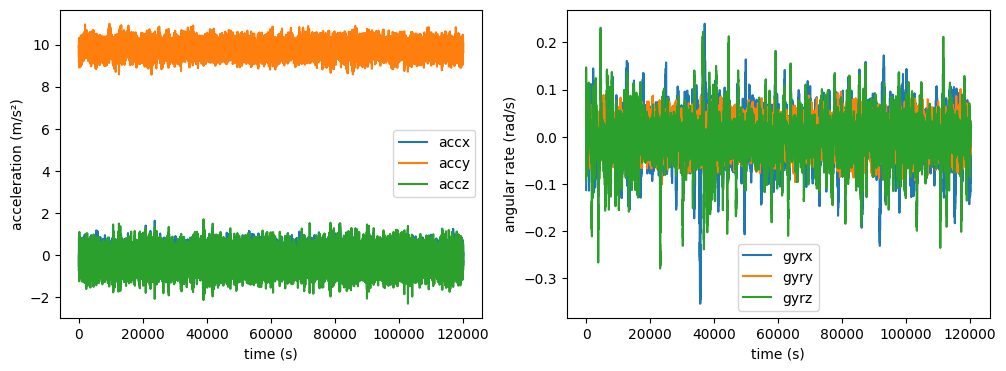

In [16]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
for i in range(3):
    ax[0].plot(ts,acceleration_xyz[:,i],label = acc_plot_label[i])
    ax[0].set_xlabel('time (s)')
    ax[0].set_ylabel('acceleration (m/s²)')
    ax[0].legend()
    ax[1].plot(ts,rotationrate_xyz[:,i],label = gyr_plot_label[i])
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('angular rate (rad/s)')
    ax[1].legend()

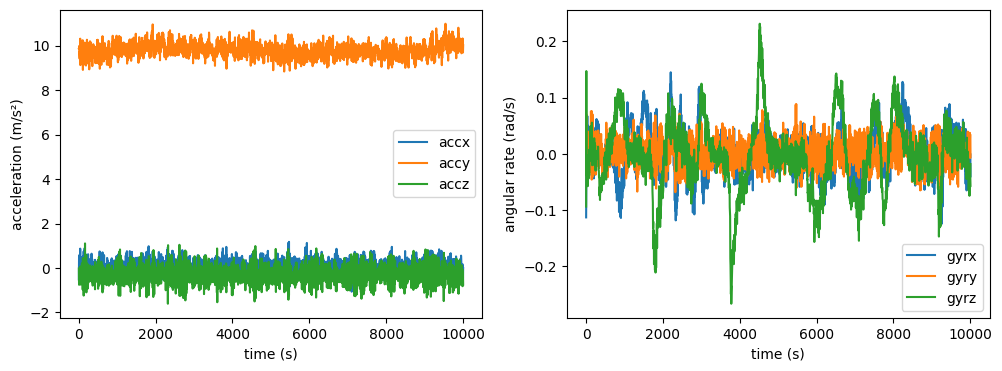

In [27]:
# zoom in
nbs = 2000
fig,ax = plt.subplots(1,2,figsize=(12,4))
# ax[0].plot(ts[:nbs],acceleration_xyz[:nbs,1],label = acc_plot_label[1])
for i in range(3):
    ax[0].plot(ts[:nbs],acceleration_xyz[:nbs,i],label = acc_plot_label[i])
    ax[0].set_xlabel('time (s)')
    ax[0].set_ylabel('acceleration (m/s²)')
    ax[0].legend()
    ax[1].plot(ts[:nbs],rotationrate_xyz[:nbs,i],label = gyr_plot_label[i])
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('angular rate (rad/s)')
    ax[1].legend()

## time stamps
Allows to get the actuall sampling frequency

In [7]:
NBINS = 200
TS_SAMP_0 = tot_nb_sample//2
TS_SAMP_1 = TS_SAMP_0 + tot_nb_sample//8 # take 1/4 of the total of samples
acc_ts_grad=np.gradient(acc_ts[TS_SAMP_0:TS_SAMP_1]) # remove the first sample which is off
gyro_ts_grad=np.gradient(ts[TS_SAMP_0:TS_SAMP_1])
print(len(acc_ts_grad[TS_SAMP_0:TS_SAMP_1]))
# idx_high_ts = np.where(acc_ts_grad < 1.0)
# print(idx_high_ts)
# print(f'{acc_ts_grad}')
# plt.hist(acc_ts_grad,NBINS)
print(TS_SAMP_0,TS_SAMP_1)
print(acc_ts_grad)

0
12000 15000
[5.006 5.006 5.006 ... 5.006 5.006 5.006]


Note:

In some data samples, the accelerometer time stamp has an 'outlier' at the last bin.

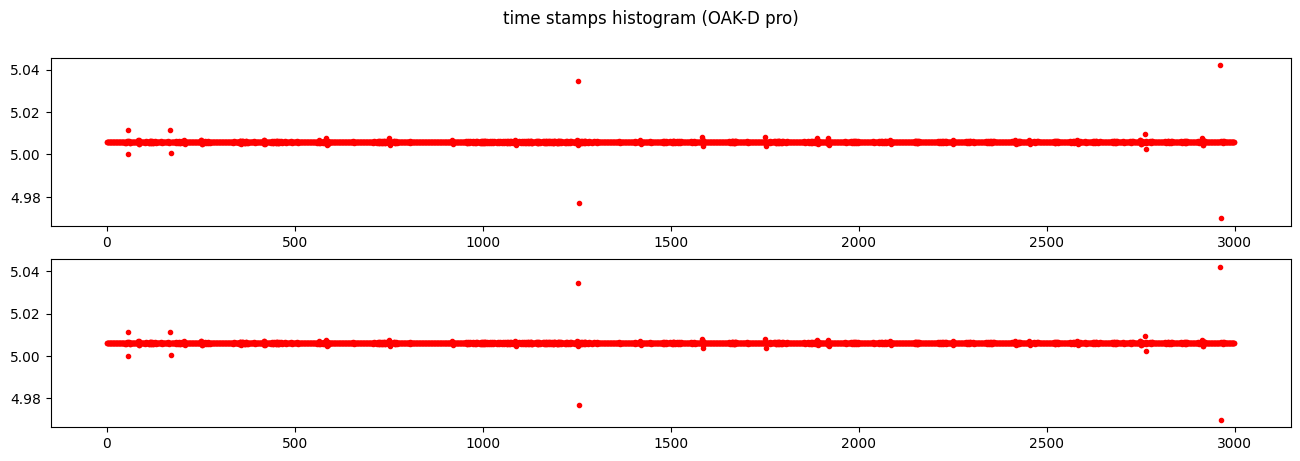

In [8]:
# idx_non0bin_ts = np.where(acc_ts_grad > 12.0)
# print(idx_high_ts)
f, axarr = plt.subplots(2, sharex=False)
# f.set_figheight(12)
f.set_figwidth(16)
f.suptitle(f'time stamps histogram (OAK-D pro)',fontsize = 12)
axarr[0].plot(acc_ts_grad, 'r.',label='accel time stamp') # alpha=0.1 is the opacity (alpha in 0 - 1 range)
axarr[1].plot(gyro_ts_grad, 'r.',label='accel time stamp') # alpha=0.1 is the opacity (alpha in 0 - 1 range)

Gaussian best fit mu, sigma = ((4.970000000001164, 5.04182000000128, 5.006004666666671), (0.0, 0.00018000000000029104, 0.001238875117028848))
lower FS ts: (5.006004666666671, 0.001238875117028848))
gauss_fit_accts_low 
[nan]


/home/ludofw/.virtualenvs/depthai/lib/python3.10/site-packages/scipy-1.13.0rc1-py3.10-linux-x86_64.egg/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


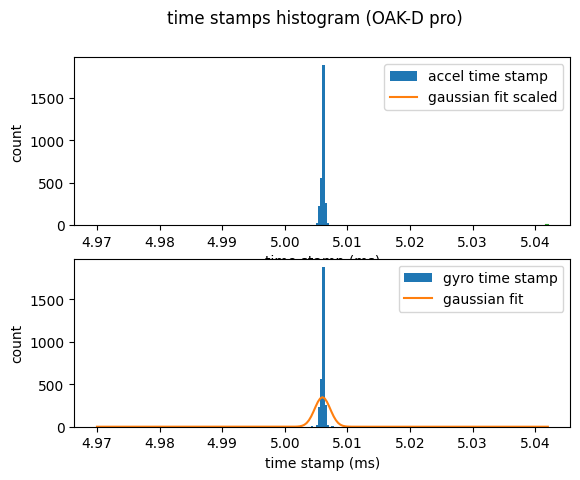

In [9]:
f, axarr = plt.subplots(2, sharex=False)
# f.set_figheight(12)
# f.set_figwidth(8)
f.suptitle(f'time stamps histogram (OAK-D pro)',fontsize = 12)
acc_cnt, bins_acc_ts, b = axarr[0].hist(acc_ts_grad, NBINS , density=False, label='accel time stamp') # alpha=0.1 is the opacity (alpha in 0 - 1 range)
gyr_cnt, bins_gyro_ts, _ = axarr[1].hist(gyro_ts_grad, NBINS, density=False, label='gyro time stamp') #, density=1, alpha=0.5,label='gyro time stamp')

# split the time stamp histo of the slowest sensor (the one with the smallest sampling rate)
idx_bin_0_ts = np.where(acc_cnt == 0.0)[0]
# print(idx_bin_0_ts)
idx_low_bins_ts = idx_bin_0_ts[0] # end index for which the histo count is not zero (lower ts)
idx_hi_bins_ts = idx_bin_0_ts[-1]+1 # start index from which the histo count is not zero (higher ts)
# print(idx_bin_0_ts,idx_low_bins_ts,idx_hi_bins_ts)
# print(idx_low_bins_ts,idx_hi_bins_ts)

bins_acc_low_ts = bins_acc_ts[:idx_low_bins_ts]
bins_acc_hi_ts = bins_acc_ts[idx_hi_bins_ts:]

cnt_acc_low_ts = acc_cnt[:idx_low_bins_ts]
cnt_acc_hi_ts = acc_cnt[idx_hi_bins_ts:]
# print(idx_hi_bins_ts)
# print(bins_acc_low_ts, bins_acc_hi_ts, acc_cnt[idx_hi_bins_ts])
# pouet
SHOW_HISTO_DETAILS = False
if SHOW_HISTO_DETAILS:   
    with np.printoptions(precision=3, suppress=True):
        print(f'acc_cnt {acc_cnt}\n,bins_acc_ts {bins_acc_ts}\n b {b}')
        print(f'gyr_cnt = {gyr_cnt},\nbins_gyro_ts {bins_gyro_ts}')
'''
# axarr[0].set_title('Gyro Angular rate X')
accel_expectd_fit=(1.7,.06,100,3,0.06,200)
# Create an array of length num_bins containing the center of each bin.

centers = 0.5*(bins_acc_ts[:-1] + bins_acc_ts[1:])
acc_params,acc_cov=curve_fit(bimodal,acc_cnt,centers,accel_expectd_fit)

# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(gyro_ts_grad)),gyro_ts_grad,gyro_expectd_fit)
# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(acc_ts_grad)),acc_ts_grad,expected)
acc_sigma=np.sqrt(np.diag(acc_cov))
if SHOW_HISTO_DETAILS:   
    print(f'acc_params {acc_params} ,{acc_sigma}')  

gyro_expectd_fit=(2.5,.06,70)
# Create an array of length num_bins containing the center of each bin.
gyro_bin_centers = 0.5*(bins_gyro_ts[:-1] + bins_gyro_ts[1:])
gyr_params,gyr_cov=curve_fit(gauss,gyr_cnt,gyro_bin_centers,gyro_expectd_fit)
# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(gyro_ts_grad)),gyro_ts_grad,gyro_expectd_fit)
# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(acc_ts_grad)),acc_ts_grad,expected)
gyr_sigma=np.sqrt(np.diag(gyr_cov))
print(f'gyr_params {gyr_params} ,{gyr_sigma}')  
# params,cov=curve_fit(bimodal,bins_acc_ts,expected)
# print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
'''
'''
# yet another way for the fit
from scipy.optimize import leastsq
# fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2)+p[3]
fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2)
errfunc  = lambda p, x, y: (y - fitfunc(p, x))
init  = [1.0, 0.5, 0.5]
# init  = [1.0, 0.5, 0.5, 0.5]
out   = leastsq( errfunc, init, args=(gyr_cnt,gyro_bin_centers))
c = out[0]
print("Fit Coefficients:")
print(c[0],c[1],abs(c[2]))
# print(c[0],c[1],abs(c[2]),c[3])
'''

mu, sigma = zip(stats.norm.fit(bins_acc_low_ts),stats.norm.fit(bins_acc_hi_ts),stats.norm.fit(gyro_ts_grad))
mu_lowts, sigma_lowts = stats.norm.fit(acc_ts_grad)


print(f'Gaussian best fit mu, sigma = {mu,sigma}\nlower FS ts: {mu_lowts,sigma_lowts})')
# gauss_fit_accts = stats.norm.pdf(bins_acc_ts, mu[0], sigma[0])
gauss_fit_accts_low_ts = stats.norm.pdf(bins_acc_low_ts, mu[0], sigma[0])
gauss_fit_accts_hi_ts = stats.norm.pdf(bins_acc_hi_ts, mu[1], sigma[1])
gauss_fit_gyrots =  stats.norm.pdf(bins_gyro_ts, mu[2], sigma[2])
# gauss_fit_gyrots = 1/sigma[1]* stats.norm.pdf(bins_gyro_ts, mu[1], sigma[1])
# axarr[0].plot(bins_acc_low_ts,gauss_fit_accts_low_ts,label = 'gaussian fit')
axarr[0].plot(bins_acc_low_ts,sum(cnt_acc_low_ts)*gauss_fit_accts_low_ts/sum(gauss_fit_accts_low_ts),label = 'gaussian fit scaled')
axarr[0].plot(bins_acc_hi_ts,sum(cnt_acc_hi_ts)*gauss_fit_accts_hi_ts/sum(gauss_fit_accts_hi_ts))
# axarr[0].plot(bins_acc_ts,gauss_fit_accts,label = 'gaussian fit')
# axarr[0].plot(bins_acc_ts,bimodal(bins_acc_ts,*acc_params),'r+',label = 'bimodal fit')

# axarr[1].plot(bins_gyro_ts,1/sigma[1]*gauss_fit_gyrots,label = 'gaussian fit')
axarr[1].plot(bins_gyro_ts,sum(gyr_cnt)*gauss_fit_gyrots/sum(gauss_fit_gyrots),label = 'gaussian fit')
# axarr[1].plot(bins_gyro_ts, fitfunc(c, bins_gyro_ts))
# axarr[1].plot(bins_gyro_ts,gauss(bins_gyro_ts,*gyr_params),label = 'curve fit')
with np.printoptions(precision=3, suppress=True):
    print(f'gauss_fit_accts_low \n{gauss_fit_accts_low_ts}')
    # print(f'gauss_fit_accts \n{gauss_fit_accts}')
for i in range(2):
    # axarr[i].grid()
    axarr[i].set_ylabel('count')
    axarr[i].set_xlabel('time stamp (ms)')
    axarr[i].legend()
# print(dataArr.shape)
# f.savefig('test.png', bbox_inches='tight')

In [10]:
# average sampling time period (ts is in ms)
fs_actual = 1000 / mu[2]
print(f'average sampling period = {mu[2]:.2}ms \n'
      f'actual sampling frequency = {fs_actual}')

average sampling period = 5.0ms 
actual sampling frequency = 199.76010143551588


In [11]:
print(f'average sampling period accelerometer: {np.average(acc_ts_grad):.3}ms')
print(f'average sampling period gyroscope: {np.average(gyro_ts_grad):.3}ms')

average sampling period accelerometer: 5.01ms
average sampling period gyroscope: 5.01ms


In [12]:
# print(f'{acc_ts,ts}')

bins_gx:
[-0.354 -0.351 -0.348 -0.345 -0.342 -0.339 -0.336 -0.333 -0.33  -0.327
 -0.324 -0.321 -0.318 -0.315 -0.312 -0.309 -0.306 -0.303 -0.3   -0.297
 -0.294 -0.291 -0.288 -0.285 -0.282 -0.279 -0.277 -0.274 -0.271 -0.268
 -0.265 -0.262 -0.259 -0.256 -0.253 -0.25  -0.247 -0.244 -0.241 -0.238
 -0.235 -0.232 -0.229 -0.226 -0.223 -0.22  -0.217 -0.214 -0.211 -0.208
 -0.205 -0.202 -0.199 -0.196 -0.193 -0.19  -0.188 -0.185 -0.182 -0.179
 -0.176 -0.173 -0.17  -0.167 -0.164 -0.161 -0.158 -0.155 -0.152 -0.149
 -0.146 -0.143 -0.14  -0.137 -0.134 -0.131 -0.128 -0.125 -0.122 -0.119
 -0.116 -0.113 -0.11  -0.107 -0.104 -0.101 -0.099 -0.096 -0.093 -0.09
 -0.087 -0.084 -0.081 -0.078 -0.075 -0.072 -0.069 -0.066 -0.063 -0.06
 -0.057 -0.054 -0.051 -0.048 -0.045 -0.042 -0.039 -0.036 -0.033 -0.03
 -0.027 -0.024 -0.021 -0.018 -0.015 -0.012 -0.01  -0.007 -0.004 -0.001
  0.002  0.005  0.008  0.011  0.014  0.017  0.02   0.023  0.026  0.029
  0.032  0.035  0.038  0.041  0.044  0.047  0.05   0.053  0.056  0.059


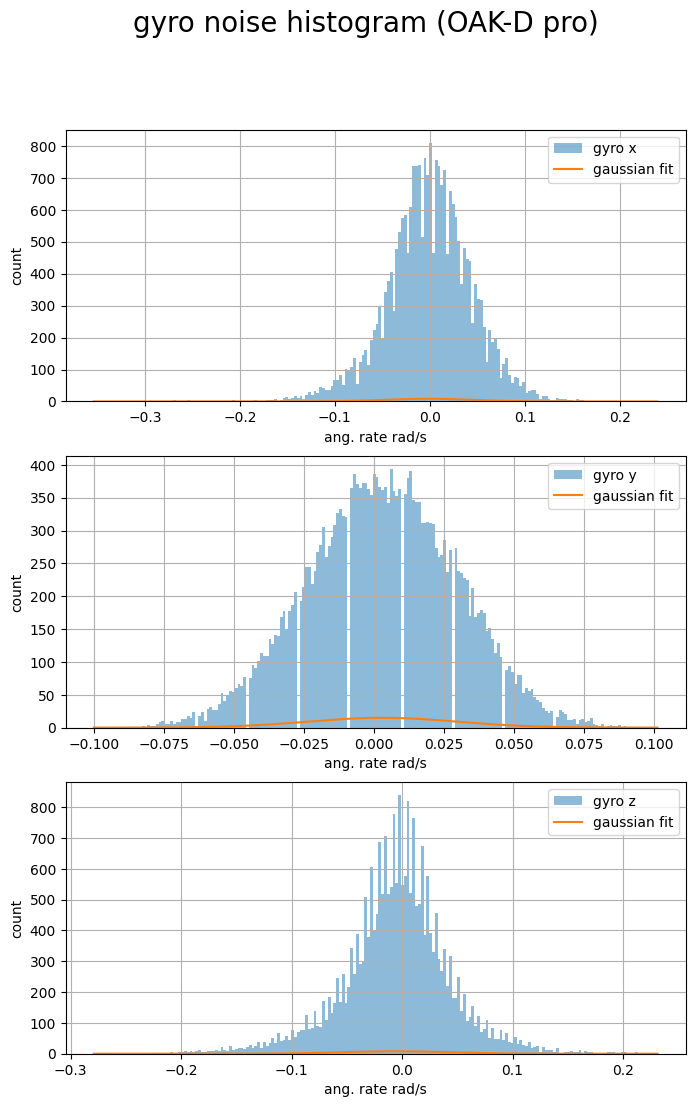

In [13]:
f, axarr = plt.subplots(3, sharex=False)
f.set_figheight(12)
f.set_figwidth(8)
f.suptitle(f'gyro noise histogram (OAK-D pro)',fontsize = 20)
histo_density = False
#axarr[0].plot(t, accX_ref, 'y.',label="ground truth AccX")
# _, bins_gx, _ = axarr[0].hist(acc_ts_grad, NBINS, density=histo_density, alpha=0.5,label='gyro x')
_, bins_gx, _ = axarr[0].hist(gx, NBINS, density=histo_density, alpha=0.5,label='gyro x')
_, bins_gy, _ = axarr[1].hist(gy, NBINS, density=histo_density, alpha=0.5,label='gyro y')
_, bins_gz, _ = axarr[2].hist(gz, NBINS, density=histo_density, alpha=0.5,label='gyro z')
np.set_printoptions()  # formatter gets reset
# reset the default print options
np.set_printoptions(edgeitems=3, infstr='inf',
                    linewidth=75, nanstr='nan', precision=8,
                    suppress=False, threshold=1000, formatter=None)
with np.printoptions(precision=3):
    print(f'bins_gx:\n{bins_gx}')
for i in range(3):
    axarr[i].grid()
    axarr[i].set_ylabel('count')
    axarr[i].set_xlabel('ang. rate rad/s')

# axarr[0].set_title('Gyro Angular rate X')

# print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
mu, sigma = zip(stats.norm.fit(gx),stats.norm.fit(gy),stats.norm.fit(gz))

print(f'Gaussian best fit mu, sigma = {mu,sigma}')
gauss_fit_gx = stats.norm.pdf(bins_gx, mu[0], sigma[0])
gauss_fit_gy = stats.norm.pdf(bins_gy, mu[1], sigma[1])
gauss_fit_gz = stats.norm.pdf(bins_gz, mu[2], sigma[2])
axarr[0].plot(bins_gx,gauss_fit_gx,label = 'gaussian fit')
axarr[1].plot(bins_gy,gauss_fit_gy,label = 'gaussian fit')
axarr[2].plot(bins_gz,gauss_fit_gz,label = 'gaussian fit')

hmx = half_max_x(bins_gx,gauss_fit_gx)

axarr[0].legend()
axarr[1].legend()
axarr[2].legend()
# plt.plot(gauss_fit_gx)
# np.set_printoptions(precision=2)
with np.printoptions(precision=3, suppress=True):
    print(f'gauss_fit_gx: \n{gauss_fit_gx}')
# np.set_printoptions()  # formatter gets reset
#axarr[0].set_ylim([-2, 2])

## same for the acceleration

Gaussian best fit mu, sigma = ((-0.00520399525, 9.697962195291666, -0.6501443125833333), (0.012620324473003621, 0.016095791704399065, 0.014934777904546318))
Magnitude of gravity vector: 9.72


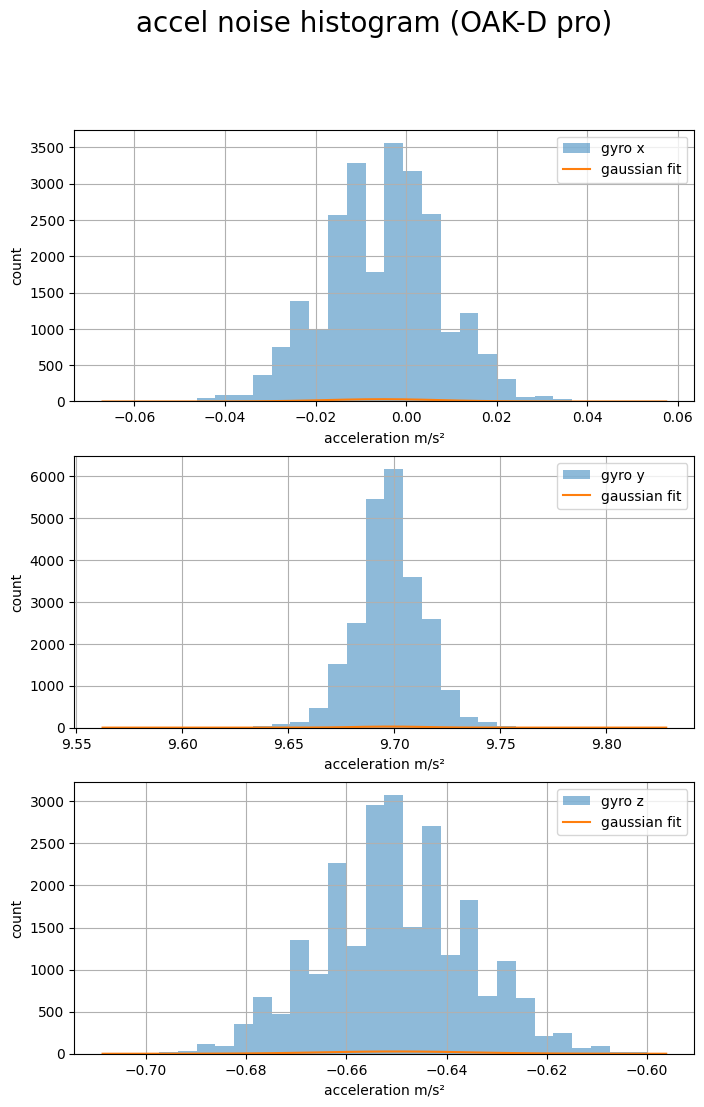

In [41]:
histo_density = False # True: draw and return a probability density, i.e. area under the histogram = 1,
                        # use False to get the real count plot
f, axarr = plt.subplots(3, sharex=False)
f.set_figheight(12)
f.set_figwidth(8)
f.suptitle(f'accel noise histogram (OAK-D pro)',fontsize = 20)
#axarr[0].plot(t, accX_ref, 'y.',label="ground truth AccX")
_, bins_accx, _ = axarr[0].hist(accx, NBINS, density=histo_density, alpha=0.5,label='gyro x')
_, bins_accy, _ = axarr[1].hist(accy, NBINS, density=histo_density, alpha=0.5,label='gyro y')
_, bins_accz, _ = axarr[2].hist(accz, NBINS, density=histo_density, alpha=0.5,label='gyro z')
for i in range(3):
    axarr[i].grid()
    axarr[i].set_ylabel('count')
    axarr[i].set_xlabel('acceleration m/s²')
    
# print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
mu, sigma = zip(stats.norm.fit(accx),stats.norm.fit(accy),stats.norm.fit(accz))

print(f'Gaussian best fit mu, sigma = {mu,sigma}')
g_eval = np.linalg.norm(mu)
print(f'Magnitude of gravity vector: {g_eval:.4}')
gauss_fit_accx = stats.norm.pdf(bins_accx, mu[0], sigma[0])
gauss_fit_accy = stats.norm.pdf(bins_accy, mu[1], sigma[1])
gauss_fit_accz = stats.norm.pdf(bins_accz, mu[2], sigma[2])
axarr[0].plot(bins_accx,gauss_fit_accx,label = 'gaussian fit')
axarr[1].plot(bins_accy,gauss_fit_accy,label = 'gaussian fit')
axarr[2].plot(bins_accz,gauss_fit_accz,label = 'gaussian fit')

# hmx = half_max_x(bins_accx,gauss_fit_accx)

axarr[0].legend()
axarr[1].legend()
axarr[2].legend()
#axarr[0].set_ylim([-2, 2])

## FFT, PSD, periododram

### understanding the FFT

https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/

https://stackoverflow.com/questions/33849059/how-does-numpy-fft-fft-work

https://stackoverflow.com/questions/33849059/how-does-numpy-fft-fft-work

### scaling

$\mathrm{PSD}=\frac{2\cdot \hat{X}}{f_s\cdot S}$

Good:
https://dsp.stackexchange.com/questions/32187/what-should-be-the-correct-scaling-for-psd-calculation-using-tt-fft


### other references

Interesting
https://dsp.stackexchange.com/questions/87723/larger-fft-vs-multiple-averaged-ffts-for-detecting-small-cw-signals

https://stackoverflow.com/questions/52690632/analyzing-seasonality-of-google-trend-time-series-using-fft/52691914#52691914


Others

- https://stackoverflow.com/questions/50550421/matlab-fft-scaling-y-axis
- https://www.mathworks.com/matlabcentral/answers/326646-the-y-axis-units-after-applying-fft
- https://www.physicsforums.com/threads/question-regarding-y-axis-units-in-fft.703689/
- https://www.mathworks.com/matlabcentral/answers/550894-confirming-correct-results-and-y-axis-of-fft

Are the units on the y-axis the same for all FFT graphs? No, the units on the y-axis in an FFT graph can vary depending on the specific signal being analyzed and the scaling factor used. It is important to carefully examine the units and scaling used in each FFT graph before making comparisons or drawing conclusions.

Reference: https://www.physicsforums.com/threads/question-regarding-y-axis-units-in-fft.703689/
What is the unit of the FFT output?
It's still a voltage. If you do a continuous Fourier transform, you go from signal to signal integrated over time, which is signal per frequency, but in a discrete Fourier transform you're just summing discrete voltages with coefficients, and the result is still a voltage. Of course if you want you can multiply it by the time interval between sample points to get a voltage per frequency unit.
https://math.stackexchange.com/questions/175043/what-is-the-unit-of-the-fft-output

Good :
https://wiki.analog.com/university/labs/noise_adalm2000

In [15]:
def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

0.138864 (2660.0874009999993+0j)


/home/ludofw/.virtualenvs/depthai/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ludofw/.virtualenvs/depthai/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


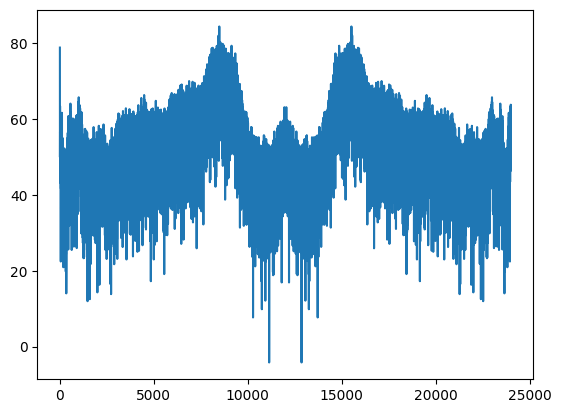

In [14]:
do_DFT_slow = False # it is slow...
if do_DFT_slow:
    DFT_slow_res= DFT_slow(accx)
    plt.plot(10.0*np.log(DFT_slow_res))
    print(accx[0],DFT_slow_res[0])

24000
np.average(accx) = -0.05727109820833333
9.770452142208335
DC components:((-2.615685446016869e-13+0j), (-2.9471536322489555e-11+0j), (-2.788880237858393e-13+0j))
1.089868935840362e-17  1.2279806801037314e-15  1.1620334324409971e-17  

figure saved to Acc_AmpFFT_BMI270_motorOn.svg


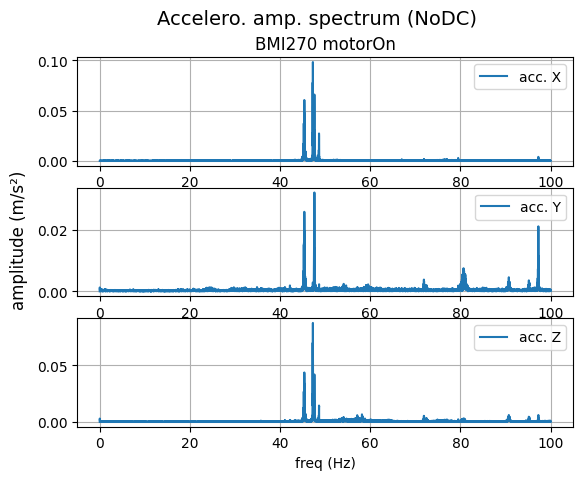

In [11]:
# about removing the DC:
# https://blog.originlab.com/how-to-remove-dc-offset-before-performing-fft
N = len(gx)  # Number of elements
if 'fs_actual' not in locals():
    fs_actual = FS
print(N)
REMOVE_DC = True
DC_RMV = ''
if REMOVE_DC:
    idx_0 = 1
    accx_dc = accx - np.average(accx)
    accy_dc = accy - np.average(accy)
    accz_dc = accz - np.average(accz)
    DC_RMV = '(NoDC)'
else:
    idx_0 = 0
    accx_dc = accx
    accy_dc = accy
    accz_dc = accz

idx_0= 0
print(f'np.average(accx) = {np.average(accx)}')

print(np.average(accy))
# Compute FFTs
freqBins = np.linspace(0, fs_actual / 2, N // 2)  # Freq. labels [Hz]
# FFT of accelerometer data
fax = np.fft.fft(accx_dc)  
fay = np.fft.fft(accy_dc)
faz = np.fft.fft(accz_dc)
print(f'DC components:{fax[0],fay[0],faz[0]}')
dccomp = np.zeros(3)
dccomp[0] = (1 / N) * np.abs(fax[0]) # was 2/N but then Dc component is 2x more than what it should be
dccomp[1] = (1 / N) * np.abs(fay[0])
dccomp[2] = (1 / N) * np.abs(faz[0])
for i in range(3):
    print(f'{dccomp[i]} ', end =" ") 
print('\n')

# fgx = np.fft.fft(gx)  # FFT of gyro data

# Plot x-accel. FFT
fig, axacc = plt.subplots(3,sharex = False) 
fig.suptitle(f"Accelero. amp. spectrum {DC_RMV}", fontsize=14)
axacc[0].set_title(f'{IMU_NAME} {TEST_CONFIG}')
axacc[0].plot(freqBins[idx_0:], (1 / N) * np.abs(fax[idx_0:N // 2]),label = 'acc. X')
axacc[1].plot(freqBins[idx_0:], (1 / N) * np.abs(fay[idx_0:N // 2]),label = 'acc. Y')
axacc[2].plot(freqBins[idx_0:], (1 / N) * np.abs(faz[idx_0:N // 2]),label = 'acc. Z')
axacc[2].set_xlabel('freq (Hz)')
# axacc[0].set_ylabel('amplitude')
fig.supylabel('amplitude (m/s²)')
for i in range(3):
    axacc[i].grid()
    axacc[i].legend()
# plt.plot(freqBins[0:], (2 / N) * np.abs(fax[0:N // 2]))
# plt.plot(freqBins[1:], (2 / N) * np.abs(fax[1:N // 2]))
# plt.title('FFT of X-Accelerometer Data')
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Amplitude')
# plt.grid()


# plt.savefig('motors60mn.png')
if SAVE_FIG:
    figname = f'Acc_AmpFFT_{FIG_FILENAME_BASE}.{FIG_FMT}'
    plt.savefig(figname)
    print(f'figure saved to {figname}')
plt.show()

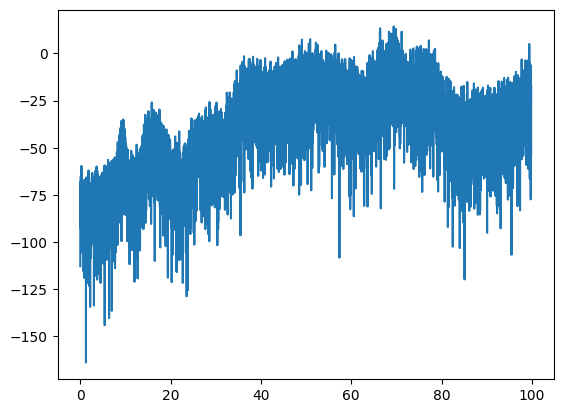

[0.0035512  0.03281375 0.03315641 0.01321417 0.01063385 0.01115665
 0.01365162 0.03185854 0.02485796 0.00972456] [0.         0.00832125 0.01664249 0.02496374 0.03328499 0.04160624
 0.04992748 0.05824873 0.06656998 0.07489123]


In [16]:
# see: https://www.analog.com/en/resources/technical-articles/use-python-for-analysis-of-noise.html
from scipy.signal import periodogram
fs,psd = periodogram(accy,fs_actual,window='blackman',return_onesided=True)
vsd = np.sqrt(psd)
vsd_dB = 10.0*np.log(vsd)
psd_dB = 10.0*np.log(psd)

# plt.plot(fs,vsd)
# plt.plot(fs,vsd_dB)
plt.plot(fs,psd_dB)
plt.show()
print(vsd[:10],fs[:10])
# The periodogram produces a power spectral density, that means it is the square of the amplitude at each frequency bin.

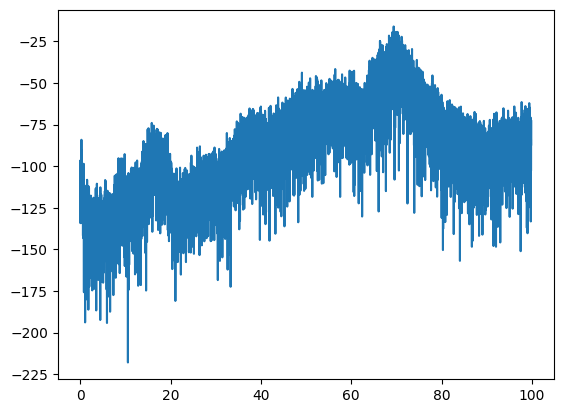

[0.00262128 0.0054572  0.00800231 0.00544695 0.00181143 0.00121697
 0.00313352 0.00697803 0.00687947 0.00184815] [0.         0.00832125 0.01664249 0.02496374 0.03328499 0.04160624
 0.04992748 0.05824873 0.06656998 0.07489123]


In [17]:
# see: https://www.analog.com/en/resources/technical-articles/use-python-for-analysis-of-noise.html
from scipy.signal import periodogram
fs,psd = periodogram(gx,fs_actual,window='blackman',return_onesided=True)
vsd = np.sqrt(psd)
vsd_dB = 10.0*np.log(vsd)
psd_dB = 10.0*np.log(psd)
# plt.plot(fs,vsd)
plt.plot(fs,psd_dB)
# plt.plot(fs,vsd_dB)
plt.show()
print(vsd[:10],fs[:10])
# The periodogram produces a power spectral density, that means it is the square of the amplitude at each frequency bin.

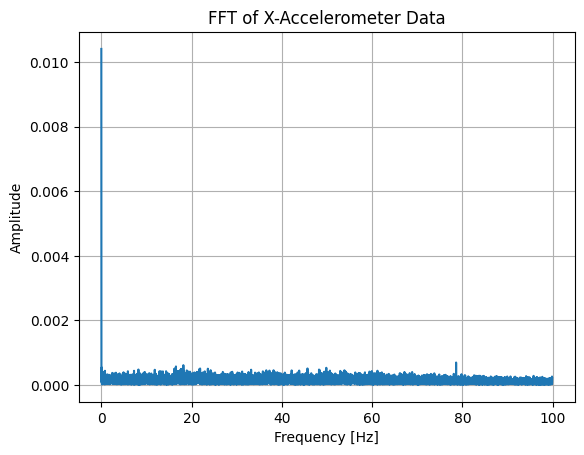

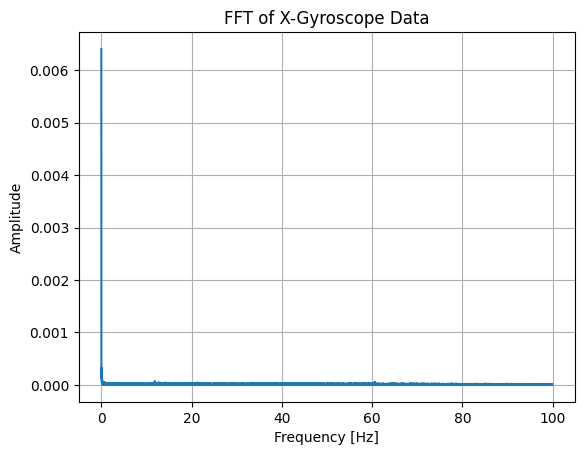

In [50]:
N = len(gx)  # Number of elements
# Compute FFTs
freqBins = np.linspace(0, fs_actual / 2, N // 2)  # Freq. labels [Hz]
# FFT of accelerometer data
fax = np.fft.fft(accx)  
fay = np.fft.fft(accy)
faz = np.fft.fft(accz)
fgx = np.fft.fft(gx)  # FFT of gyro data



# Plot x-accel. FFT

plt.plot(freqBins[0:], (2 / N) * np.abs(fax[0:N // 2]))
# plt.plot(freqBins[1:], (2 / N) * np.abs(fax[1:N // 2]))
plt.title('FFT of X-Accelerometer Data')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid()

# Plot x-gyro. FFT
plt.figure()
plt.plot(freqBins, (2 / N) * np.abs(fgx[:N // 2]))
plt.title('FFT of X-Gyroscope Data')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

## Analysis using the Welsh Method

Get the noise density or white noise (in Kalibr or VINS) or integrated rate random walk.
Integrated rate for acceleration is velocity and for angular rate it's angle.
Noted N.

https://dsp.stackexchange.com/questions/81640/trying-to-understand-the-nperseg-effect-of-welch-method

See also:

https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

https://mwrona.com/posts/imu-psd/


In [39]:
fs_actual

199.72759109466682

Noise densities (N, acc_n / gyro_n) from PSD for OAKLight_BMI270_60mn_SR200_motorOn_03052024
AX Noise Density: 9.90e-03 m/s²/sqrt(Hz)
AY Noise Density: 9.04e-03 m/s²/sqrt(Hz)
AZ Noise Density: 1.10e-02 m/s²/sqrt(Hz)
GX Noise Density: 4.79e-04 rad/s/sqrt(Hz)
GY Noise Density: 6.44e-04 rad/s/sqrt(Hz)
GZ Noise Density: 3.51e-04 rad/s/sqrt(Hz)
figure saved to Acc_PSD_Welch_BMI270_motorOn.svg
figure saved to Gyro_PSD_Welch_BMI270_motorOn.svg


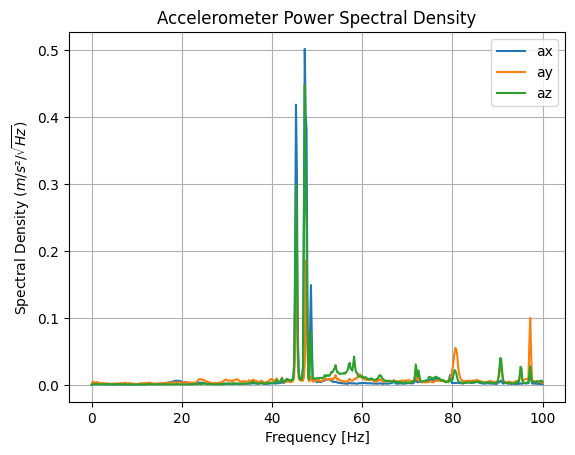

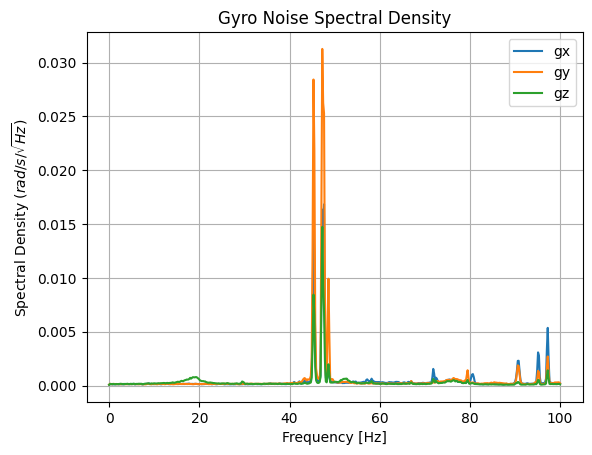

In [12]:
if ACCELERATION_UNIT_FOR_NOISE == 'm/s²':
    scale_acc_psd = 1
    acc_noise_density_unit = 'm/s²/sqrt(Hz)'
    acc_ylabel = r'Spectral Density ($m/s²  / \sqrt{Hz}$)'
elif ACCELERATION_UNIT_FOR_NOISE == 'ug':
    scale_acc_psd = MS2_TO_MICROG
    acc_noise_density_unit = r'Spectral Density  $\mu g  / \sqrt{Hz}$'# 'ug/sqrt(Hz)'
    acc_ylabel = r'Spectral Density  $\mu g  / \sqrt{Hz}$'
if ANGLE_UNIT_FOR_NOISE == 'rad':
    scale_gyr_psd = 1
    gyr_noise_density_unit = 'rad/s/sqrt(Hz)'
    gyr_ylabel = r'Spectral Density ($rad/s  / \sqrt{Hz}$)'
elif ANGLE_UNIT_FOR_NOISE == 'deg':
    scale_gyr_psd = RAD_2_DEG
    gyr_noise_density_unit = '°/s/sqrt(Hz)'
    gyr_ylabel = r'Spectral Density ($°/s  / \sqrt{Hz}$)'
print(f'Noise densities (N, acc_n / gyro_n) from PSD for {MEAS_FILENAME_NO_EXT}')

# Compute PSD via Welch algorithm
freqax, psdax = signal.welch(accx, fs_actual, nperseg=1024, scaling='density')  # ax
freqay, psday = signal.welch(accy, fs_actual, nperseg=1024, scaling='density')  # ay
freqaz, psdaz = signal.welch(accz, fs_actual, nperseg=1024, scaling='density')  # az

freqgx, psdgx = signal.welch(gx, fs_actual, nperseg=1024, scaling='density')  # gx
freqgy, psdgy = signal.welch(gy, fs_actual, nperseg=1024, scaling='density')  # gy
freqgz, psdgz = signal.welch(gz, fs_actual, nperseg=1024, scaling='density')  # gz

# scale depending on target units
psdax = np.sqrt(psdax) * scale_acc_psd
psday = np.sqrt(psday) * scale_acc_psd
psdaz = np.sqrt(psdaz) * scale_acc_psd

psdgx = np.sqrt(psdgx) * scale_gyr_psd
psdgy = np.sqrt(psdgy) * scale_gyr_psd
psdgz = np.sqrt(psdgz) * scale_gyr_psd

# Compute noise spectral densities
ndax = np.mean(psdax)
nday = np.mean(psday)
ndaz = np.mean(psdaz)
print(f'AX Noise Density: {ndax:.{PRECI}{TYPE}} {acc_noise_density_unit}')
print(f'AY Noise Density: {nday:.{PRECI}{TYPE}} {acc_noise_density_unit}')
print(f'AZ Noise Density: {ndaz:.{PRECI}{TYPE}} {acc_noise_density_unit}')
# print('AY Noise Density: %f ug/sqrt(Hz)' % (nday))
# print('AZ Noise Density: %f ug/sqrt(Hz)' % (ndaz))

ndgx = np.mean(psdgx)
ndgy = np.mean(psdgy)
ndgz = np.mean(psdgz)
print(f'GX Noise Density: {ndgx:.{PRECI}{TYPE}} {gyr_noise_density_unit}')
print(f'GY Noise Density: {ndgy:.{PRECI}{TYPE}} {gyr_noise_density_unit}')
print(f'GZ Noise Density: {ndgz:.{PRECI}{TYPE}} {gyr_noise_density_unit}')

# print('GX Noise Density: %f dps/sqrt(Hz)' % (ndgx))
# print('GY Noise Density: %f dps/sqrt(Hz)' % (ndgy))
# print('GZ Noise Density: %f dps/sqrt(Hz)' % (ndgz))


# Plot accel. data
plt.figure()
plt.plot(freqax, psdax, label='ax')
plt.plot(freqay, psday, label='ay')
plt.plot(freqaz, psdaz, label='az')
plt.title('Accelerometer Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel(acc_ylabel)
# plt.ylabel(r'Spectral Density  $\mu g  / \sqrt{Hz}$')
plt.legend()
plt.grid()
if SAVE_FIG:
    figname = f'Acc_PSD_Welch_{FIG_FILENAME_BASE}.{FIG_FMT}'
    plt.savefig(figname)
    print(f'figure saved to {figname}')

# Plot gyro data
plt.figure()
plt.plot(freqgx, psdgx, label='gx')
plt.plot(freqgy, psdgy, label='gy')
plt.plot(freqgz, psdgz, label='gz')
plt.title('Gyro Noise Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel(gyr_ylabel)

# plt.ylabel(r'Spectral Density  $dps  / \sqrt{Hz}$')
plt.legend()
plt.grid()
if SAVE_FIG:
    figname = f'Gyro_PSD_Welch_{FIG_FILENAME_BASE}.{FIG_FMT}'
    plt.savefig(figname)
    print(f'figure saved to {figname}')
plt.show()

### in dB

AX Noise Density: 125.678580 ug/sqrt(Hz)
AY Noise Density: 143.281663 ug/sqrt(Hz)
AZ Noise Density: 135.102664 ug/sqrt(Hz)
GX Noise Density: 0.000105 dps/sqrt(Hz)
GY Noise Density: 0.000107 dps/sqrt(Hz)
GZ Noise Density: 0.000102 dps/sqrt(Hz)


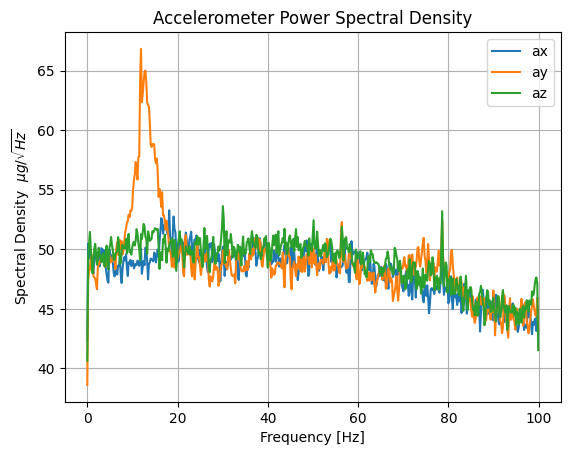

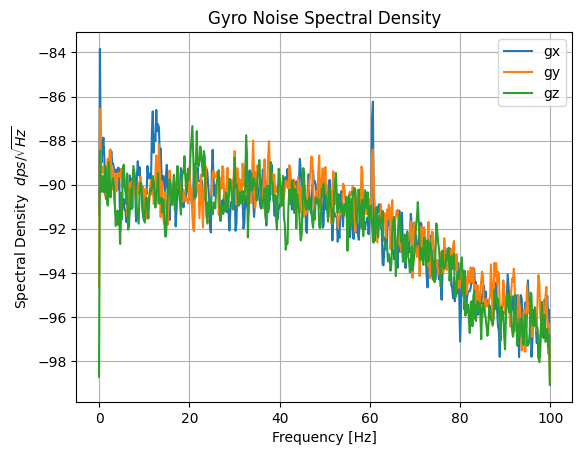

In [67]:
from scipy import signal
# m/s² to μg
MS2_TO_MICROG = 1e6 / 9.81

# Compute PSD via Welch algorithm
freqax, psdax = signal.welch(accx, fs_actual, nperseg=1024, scaling='density')  # ax
freqay, psday = signal.welch(accy, fs_actual, nperseg=1024, scaling='density')  # ay
freqaz, psdaz = signal.welch(accz, fs_actual, nperseg=1024, scaling='density')  # az

freqgx, psdgx = signal.welch(gx, fs_actual, nperseg=1024, scaling='density')  # gx
freqgy, psdgy = signal.welch(gy, fs_actual, nperseg=1024, scaling='density')  # gy
freqgz, psdgz = signal.welch(gz, fs_actual, nperseg=1024, scaling='density')  # gz

# Convert to [ug / sqrt(Hz)]
psdax = np.sqrt(psdax) * MS2_TO_MICROG
psday = np.sqrt(psday) * MS2_TO_MICROG
psdaz = np.sqrt(psdaz) * MS2_TO_MICROG

# take the dB
psdax_dB = 10*np.log(psdax)
psday_dB = 10*np.log(psday)
psdaz_dB = 10*np.log(psdaz)

psdgx = np.sqrt(psdgx)
psdgy = np.sqrt(psdgy)
psdgz = np.sqrt(psdgz)

# take the dB
psdgx_dB = 10*np.log(psdgx)
psdgy_dB = 10*np.log(psdgy)
psdgz_dB = 10*np.log(psdgz)

# Compute noise spectral densities
ndax = np.mean(psdax)
nday = np.mean(psday)
ndaz = np.mean(psdaz)
print('AX Noise Density: %f ug/sqrt(Hz)' % (ndax))
print('AY Noise Density: %f ug/sqrt(Hz)' % (nday))
print('AZ Noise Density: %f ug/sqrt(Hz)' % (ndaz))

ndgx = np.mean(psdgx)
ndgy = np.mean(psdgy)
ndgz = np.mean(psdgz)
print('GX Noise Density: %f dps/sqrt(Hz)' % (ndgx))
print('GY Noise Density: %f dps/sqrt(Hz)' % (ndgy))
print('GZ Noise Density: %f dps/sqrt(Hz)' % (ndgz))


# Plot accel. data
plt.figure()
plt.plot(freqax, psdax_dB, label='ax')
plt.plot(freqay, psday_dB, label='ay')
plt.plot(freqaz, psdaz_dB, label='az')
plt.title('Accelerometer Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Spectral Density  $\mu g / \sqrt{Hz}$')
plt.legend()
plt.grid()

# Plot gyro data
plt.figure()
plt.plot(freqgx, psdgx_dB, label='gx')
plt.plot(freqgy, psdgy_dB, label='gy')
plt.plot(freqgz, psdgz_dB, label='gz')
plt.title('Gyro Noise Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Spectral Density  $dps / \sqrt{Hz}$')
plt.legend()
plt.grid()
plt.show()

In [37]:
# from ardupilot testfilter, window is wrong, it's hann or hamming (was 'hanning')
FFT_N = 512
def create_spectrogram_ardu_updted(data, name, sample_rate):

    freqs, times, Sx = signal.spectrogram(np.array(data), fs=sample_rate, window='hann',
                      nperseg=FFT_N, noverlap=FFT_N - FFT_N // 10,
                      detrend=False, scaling='spectrum')
    
    f, ax = plt.subplots(figsize=(4.8, 2.4))
    ax.pcolormesh(times, freqs, 10 * np.log10(Sx), cmap='viridis')
    ax.set_title(name)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')


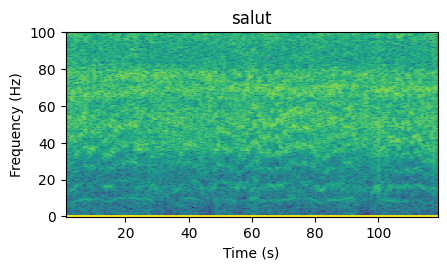

In [134]:
create_spectrogram_ardu_updted(accy,'salut',200)

In [128]:
# notes:
# for a one-dimensional x, a complex 2d array is returned, with axis 0 representing frequency and axis 1 the time slices.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ShortTimeFFT.stft.html#scipy.signal.ShortTimeFFT.stft
# other references:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ShortTimeFFT.spectrogram.html#scipy.signal.ShortTimeFFT.spectrogram
# comparison between legaxy (as in ardupilot) and new approaches:
# https://docs.scipy.org/doc/scipy/tutorial/signal.html#tutorial-stft-legacy-stft

def create_spectrogram(data, name, sample_rate):
    print(len(data))
    # SFT = signal.ShortTimeFFT(data, hop=10, fs=sample_rate, mfft=2400, scale_to='magnitude')
    # SFT = signal.ShortTimeFFT(data, hop=1, fs=sample_rate, scale_to='magnitude')
    SFT = signal.ShortTimeFFT(data, hop=10, fs=sample_rate, scale_to='psd')
    Sx = SFT.stft(data)  # perform the STFT
    t_x = np.arange(N) / sample_rate  # time indexes for signal
    fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit
    t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
    ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
                  rf"$\sigma_t={g_std*SFT.T}\,$s)")
    ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
                   rf"$\Delta t = {SFT.delta_t:g}\,$s)",
            ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
                   rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
            xlim=(t_lo, t_hi))
    
    # im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',extent=SFT.extent(N//4), cmap='viridis')
    # im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',extent=SFT.extent(N), cmap='viridis')
    Sx2 = SFT.spectrogram(data)  # calculate absolute square of STFT
    Sx_dB = 10 * np.log10(np.fmax(Sx2, 1e-4))  # limit range to -40 dB
    im1 = ax1.imshow(Sx_dB, origin='lower', aspect='auto',extent=SFT.extent(N), cmap='viridis')
    # times = np.arange(len(data))/sample_rate
    times = Sx[0,:]
    freqs = Sx[:,0]
    # times = times[0]
    # times = Sx[1][0]
    # freqs = Sx[0][0]
    print(f'dimensions of Sx = {Sx.shape},time samples size = {times.shape}'
        f'freq samples size = {freqs.shape}')
    # im1= ax1.pcolormesh(times, freqs, 10 * np.log10(Sx[:-1,:-1]), cmap='viridis')

    # ax1.plot(t_x, f_i, 'r--', alpha=.5, label='$f_i(t)$')
    fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")
    
    # Shade areas where window slices stick out to the side:
    for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                     (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
        ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
    for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
        ax1.axvline(t_, color='y', linestyle='--', alpha=0.5)
    ax1.legend()
    fig1.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4000
dimensions of Sx = (2001, 799),time samples size = (799,)freq samples size = (2001,)


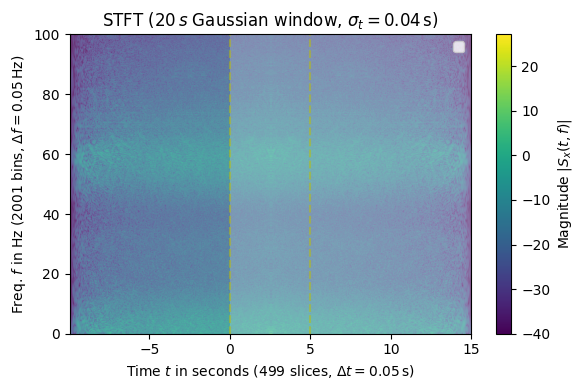

In [133]:
create_spectrogram(accz[1000:5000],'salut',200)
# create_spectrogram(accy,'salut',200)

50


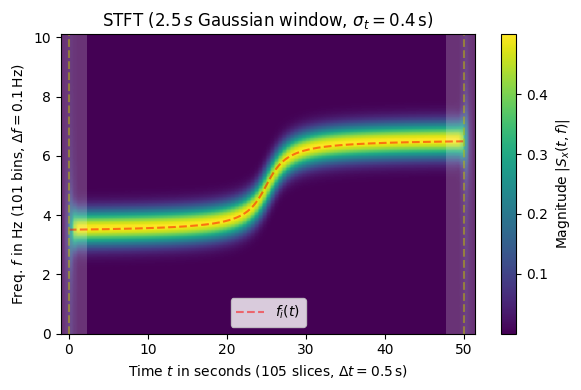

In [47]:
# spectrogram from scipy example
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

T_x, N = 1 / 20, 1000  # 20 Hz sampling rate for 50 s signal
t_x = np.arange(N) * T_x  # time indexes for signal
f_i = 1 * np.arctan((t_x - t_x[N // 2]) / 2) + 5  # varying frequency
x = np.sin(2*np.pi*np.cumsum(f_i)*T_x) # the signal
g_std = 8  # standard deviation for Gaussian window in samples
w = gaussian(50, std=g_std, sym=True)  # symmetric Gaussian window
print(len(w))
SFT = ShortTimeFFT(w, hop=10, fs=1/T_x, mfft=200, scale_to='magnitude')
Sx = SFT.stft(x)  # perform the STFT
fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={g_std*SFT.T}\,$s)")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')
ax1.plot(t_x, f_i, 'r--', alpha=.5, label='$f_i(t)$')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax1.axvline(t_, color='y', linestyle='--', alpha=0.5)
ax1.legend()
fig1.tight_layout()
plt.show()


25 961 (25, 961)


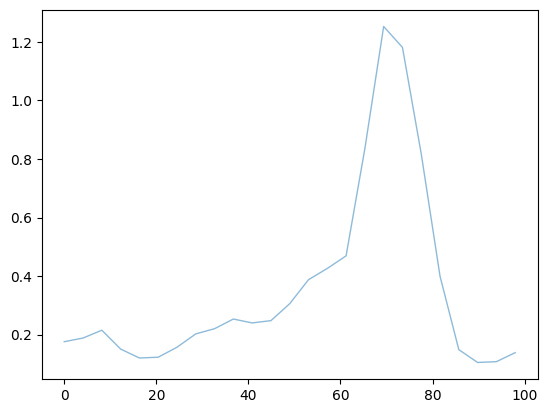

In [29]:
# freqs, time, Zxx = signal.spectral.stft(accy, fs=fs_actual, 
freqs_x, time_x, Zxx = signal.stft(accx, fs=200, window='hann', nperseg=fs_actual//4)
print(freqs_x.size, time_x.size, Zxx.shape)

# _freqs_raw_y, _times_raw_y, _stft_raw_y = signal.stft(Ys, sample_rate, window='hann', nperseg=self.FFT_N)
raw_fft_x = np.average(np.abs(Zxx), axis=1)
fig, ax = plt.subplots(1)
ax.plot(freqs_x, raw_fft_x, alpha=0.5, linewidth=1, label="{}x FFT".format(accx))


In [27]:
# freqs, time, Zxx = signal.spectral.stft(accy, fs=fs_actual, 
freqs, time, Zxx = signal.stft(accy, fs=fs_actual,                                         
                               nfft=fs_actual//4, nperseg=fs_actual//4, noverlap=fs_actual//8,)
print(freqs.size, time.size, Zxx.shape)

_freqs_raw_y, _times_raw_y, _stft_raw_y = signal.stft(Ys, sample_rate, window='hann', nperseg=self.FFT_N)
        raw_fft_y = np.average(np.abs(_stft_raw_y), axis=1)


25 961 (25, 961)


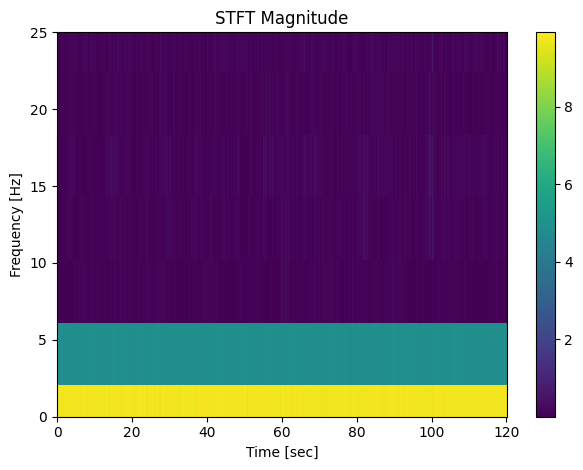

In [23]:
plt.pcolormesh(time, freqs, np.abs(Zxx), #shading='gouraud' # interpolate the image 
              )
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 25)
plt.colorbar()
plt.tight_layout()
plt.show()

Now calculate the Allan variance. The module ``allan`` is not provided by ``pyplnoise``, but many similar codes can be found on pypi.

In [55]:
import allantools
# import allan_variance

In [56]:
# accelerometer
t = np.logspace(0, 3, 1000)  # tau values from 1 to 1000
# t = 'all'
(t2_accx, ad_accx, ade_accx, adn_accx) = allantools.oadev(accx, rate=fs_actual, data_type="freq", taus=t)  # Compute the overlapping ADEV
(t2_accy, ad_accy, ade_accy, adn_accy) = allantools.oadev(accy, rate=fs_actual, data_type="freq", taus=t)  # Compute the overlapping ADEV
(t2_accz, ad_accz, ade_accz, adn_accz) = allantools.oadev(accz, rate=fs_actual, data_type="freq", taus=t)  # Compute the overlapping ADEV
print(len(t))

1000


In [65]:
# gyroscope
t = np.logspace(0, 3, 1000)  # tau values from 1 to 1000
# t = 'all'
(t2_gyrx, ad_gyrx, ade_gyrx, adn_gyrx) = allantools.oadev(gx, rate=fs_actual, data_type="freq", taus=t)  # Compute the overlapping ADEV
(t2_gyry, ad_gyry, ade_gyry, adn_gyry) = allantools.oadev(gy, rate=fs_actual, data_type="freq", taus=t)  # Compute the overlapping ADEV
(t2_gyrz, ad_gyrz, ade_gyrz, adn_gyrz) = allantools.oadev(gz, rate=fs_actual, data_type="freq", taus=t)  # Compute the overlapping ADEV
print(len(t))

1000


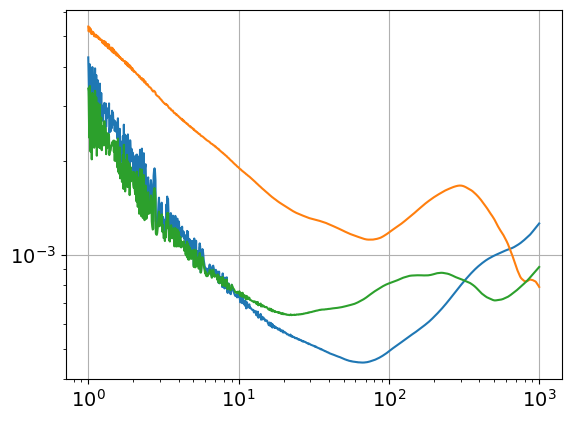

In [57]:

fig = plt.loglog(t2_accx, ad_accx) # P
plt.loglog(t2_accy, ad_accy) # P
plt.loglog(t2_accz, ad_accz) # P
plt.grid()

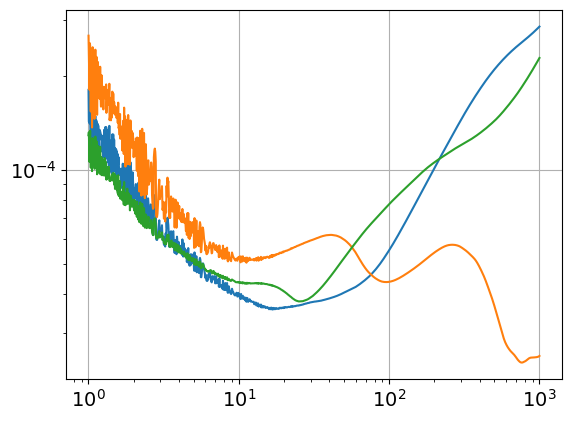

In [66]:

fig = plt.loglog(t2_gyrx, ad_gyrx) # P
plt.loglog(t2_gyry, ad_gyry) # P
plt.loglog(t2_gyrz, ad_gyrz) # P
plt.grid()

In [58]:
print(t2_accx[:10], ad_accx[:10], ade_accx[:10], adn_accx[:10])
print(t2_accy[:10], ad_accy[:10], ade_accy[:10], adn_accy[:10])
print(t2_accz[:10], ad_accz[:10], ade_accz[:10], adn_accz[:10])
# print(ad[0])

[1.0013639  1.00637072 1.01638436 1.02139118 1.026398   1.03641164
 1.04141846 1.0514321  1.05643892 1.06645256] [0.00427817 0.00383802 0.00297629 0.00405056 0.00406492 0.00261068
 0.00370601 0.00319789 0.00238173 0.00398401] [5.04326840e-06 4.52441085e-06 3.50857642e-06 4.77498286e-06
 4.79191344e-06 3.07760206e-06 4.36882927e-06 3.76984604e-06
 2.80772149e-06 4.69659269e-06] [719601. 719599. 719595. 719593. 719591. 719587. 719585. 719581. 719579.
 719575.]
[1.0013639  1.00637072 1.01638436 1.02139118 1.026398   1.03641164
 1.04141846 1.0514321  1.05643892 1.06645256] [0.00536992 0.00518529 0.00522944 0.00533551 0.00519338 0.00515009
 0.00527431 0.00508051 0.00508462 0.00517699] [6.33026228e-06 6.11262400e-06 6.16468717e-06 6.28973622e-06
 6.12219188e-06 6.07117568e-06 6.21762737e-06 5.98917899e-06
 5.99402962e-06 6.10294015e-06] [719601. 719599. 719595. 719593. 719591. 719587. 719585. 719581. 719579.
 719575.]
[1.0013639  1.00637072 1.01638436 1.02139118 1.026398   1.03641164
 1.0414

In [59]:
# print(t2, ad, ade, adn)
# K_idx0 = t2.any(t2 < 1.01 and t2>0.9)
Naccx_idx0 = np.where((t2_accx < 1.01) & (t2_accx>0.9))[0]
Naccy_idx0 = np.where((t2_accy < 1.01) & (t2_accy>0.9))[0]
Naccz_idx0 = np.where((t2_accz < 1.01) & (t2_accz>0.9))[0]

accx_noise_density = ad_accx[Naccx_idx0[0]]
accy_noise_density = ad_accy[Naccy_idx0[0]]
accz_noise_density = ad_accz[Naccz_idx0[0]]

print("Velocity random walk or acc. noise density, white noise: sigma a, Na ")
# print("sigma ax, Nax = {:.4g} °/s/sqrt(Hz) = {:.5f} °/sqrt(h)"
print("sigma ax, Nax = {:.4g} m/s2/sqrt(Hz), m/s/sqrt(s) = {:.5f} m/s2/sqrt(h)"
      .format(accx_noise_density, accx_noise_density*60))
print("sigma ay, Nay = {:.4g} m/s2/sqrt(Hz), m/s/sqrt(s) = {:.5f} m/s2/sqrt(h)"
      .format(accy_noise_density, accy_noise_density*60))
print("sigma az, Naz = {:.4g} m/s2/sqrt(Hz), m/s/sqrt(s) = {:.5f} m/s2/sqrt(h)"
      .format(accz_noise_density, accz_noise_density*60))
rms_Na = np.sqrt(accx_noise_density*accx_noise_density + accy_noise_density*accy_noise_density + accz_noise_density*accz_noise_density)
print(f"sigma a rms, Na = {rms_Na:.4g} m/s2/sqrt(Hz), m/s/sqrt(s) ")

avg_Na = (accx_noise_density + accy_noise_density + accz_noise_density)/3
print(f"sigma_a avg, Na = {avg_Na:.4g} m/s2/sqrt(Hz), m/s/sqrt(s) ")


Velocity random walk or acc. noise density, white noise: sigma a, Na 
sigma ax, Nax = 0.004278 m/s2/sqrt(Hz), m/s/sqrt(s) = 0.25669 m/s2/sqrt(h)
sigma ay, Nay = 0.00537 m/s2/sqrt(Hz), m/s/sqrt(s) = 0.32220 m/s2/sqrt(h)
sigma az, Naz = 0.003398 m/s2/sqrt(Hz), m/s/sqrt(s) = 0.20389 m/s2/sqrt(h)
sigma a rms, Na = 0.007661 m/s2/sqrt(Hz), m/s/sqrt(s) 
sigma_a avg, Na = 0.004349 m/s2/sqrt(Hz), m/s/sqrt(s) 


In [69]:
# gyro
# print(t2, ad, ade, adn)
# K_idx0 = t2.any(t2 < 1.01 and t2>0.9)
Ngyrx_idx0 = np.where((t2_gyrx < 1.01) & (t2_gyrx>0.9))[0]
Ngyry_idx0 = np.where((t2_gyry < 1.01) & (t2_gyry>0.9))[0]
Ngyrz_idx0 = np.where((t2_gyrz < 1.01) & (t2_gyrz>0.9))[0]

gyrx_noise_density = ad_gyrx[Ngyrx_idx0[0]]
gyry_noise_density = ad_gyry[Ngyry_idx0[0]]
gyrz_noise_density = ad_gyrz[Ngyrz_idx0[0]]

print("Angular random walk or gyr. noise density, white noise: sigma g, Ng ")

print("sigma ax, Nax = {:.4g} rad/s/sqrt(Hz), rad/sqrt(s) WRONG = {:.5f} m/s2/sqrt(h)"
      .format(gyrx_noise_density, gyrx_noise_density*60))
print("sigma ay, Nay = {:.4g} rad/s/sqrt(Hz), rad/sqrt(s) WRONG = {:.5f} m/s2/sqrt(h)"
      .format(gyry_noise_density, gyry_noise_density*60))
print("sigma az, Naz = {:.4g} rad/s/sqrt(Hz), rad/sqrt(s) WRONG = {:.5f} m/s2/sqrt(h)"
      .format(gyrz_noise_density, gyrz_noise_density*60))
rms_Ng = np.sqrt(gyrx_noise_density*gyrx_noise_density + gyry_noise_density*gyry_noise_density + gyrz_noise_density*gyrz_noise_density)
print(f"sigma g rms, Ng = {rms_Ng:.4g} rad/s/sqrt(Hz), rad/sqrt(s) ")

avg_Ng = (gyrx_noise_density + gyry_noise_density + gyrz_noise_density)/3
print(f"sigma_g avg, Ng = {avg_Ng:.4g} rad/s/sqrt(Hz), rad/sqrt(s) ")

print(f"For VINS: x15 the above, Ng = {avg_Ng*15:.4g} rad/s/sqrt(Hz), rad/sqrt(s)")


Angular random walk or gyr. noise density, white noise: sigma g, Ng 
sigma ax, Nax = 0.00018 rad/s/sqrt(Hz), rad/sqrt(s) WRONG = 0.01080 m/s2/sqrt(h)
sigma ay, Nay = 0.0002681 rad/s/sqrt(Hz), rad/sqrt(s) WRONG = 0.01609 m/s2/sqrt(h)
sigma az, Naz = 0.0001289 rad/s/sqrt(Hz), rad/sqrt(s) WRONG = 0.00774 m/s2/sqrt(h)
sigma g rms, Ng = 0.0003477 rad/s/sqrt(Hz), rad/sqrt(s) 
sigma_g avg, Ng = 0.0001924 rad/s/sqrt(Hz), rad/sqrt(s) 
For VINS: x15 the above, Ng = 0.002885 rad/s/sqrt(Hz), rad/sqrt(s)


### Now do the same for K 

Note that for K the values below are overestimated since we obtain the RRW (Ka, Kg) directly from the ADEV plot, rather than doing a line fit.

In [63]:
# print(t2, ad, ade, adn)
# K_idx0 = t2.any(t2 < 1.01 and t2>0.9)
Kaccx_idx0 = np.where((t2_accx < 3.01) & (t2_accx>2.9))[0]
Kaccy_idx0 = np.where((t2_accy < 3.01) & (t2_accy>2.9))[0]
Kaccz_idx0 = np.where((t2_accz < 3.01) & (t2_accz>2.9))[0]
print(t2_accx[Kaccx_idx0],Kaccy_idx0)
accx_noise_density = ad_accx[Kaccx_idx0[0]]
accy_noise_density = ad_accy[Kaccy_idx0[0]]
accz_noise_density = ad_accz[Kaccz_idx0[0]]

print("Acceleration random walk: sigma ba, Ka ")
# print("sigma ax, Nax = {:.4g} °/s/sqrt(Hz) = {:.5f} °/sqrt(h)"
print("sigma ax, Nax = {:.4g} m/s2*sqrt(Hz)"
      .format(accx_noise_density))
print("sigma ay, Nay = {:.4g} m/s2*sqrt(Hz)"
      .format(accy_noise_density))
print("sigma az, Naz = {:.4g} m/s2*sqrt(Hz)"
      .format(accz_noise_density))
rms_Ka = np.sqrt(accx_noise_density*accx_noise_density + accy_noise_density*accy_noise_density + accz_noise_density*accz_noise_density)
print(f"sigma a rms, Ka = {rms_Ka:.4g} m/s2*sqrt(Hz)")

avg_Ka = (accx_noise_density + accy_noise_density + accz_noise_density)/3
print(f"(Over-estimated) avg, Ka = {avg_Ka:.4g} m/s2*sqrt(Hz) ")
print(f"For VINS: x15 the above, Ka = {avg_Ka*15:.4g} m/s2*sqrt(Hz) ")


[2.91897577 2.93900305 2.95903033 2.98406443 3.00409171] [155 156 157 158 159]
Acceleration random walk: sigma ba, Ka 
sigma ax, Nax = 0.001376 m/s2*sqrt(Hz)
sigma ay, Nay = 0.003209 m/s2*sqrt(Hz)
sigma az, Naz = 0.00127 m/s2*sqrt(Hz)
sigma a rms, Ka = 0.003716 m/s2*sqrt(Hz)
avg, Ka = 0.001952 m/s2*sqrt(Hz) 
For VINS: x15 the above, Ka = 0.02927 m/s2*sqrt(Hz) 


In [72]:
# gyro
# print(t2, ad, ade, adn)
# K_idx0 = t2.any(t2 < 1.01 and t2>0.9)
Kgyrx_idx0 = np.where((t2_gyrx < 3.01) & (t2_gyrx>2.9))[0]
Kgyry_idx0 = np.where((t2_gyry < 3.01) & (t2_gyry>2.9))[0]
Kgyrz_idx0 = np.where((t2_gyrz < 3.01) & (t2_gyrz>2.9))[0]
print(t2_gyrx[Kgyrx_idx0],Kgyrx_idx0)
gyrx_noise_density = ad_gyrx[Kgyrx_idx0[0]]
gyry_noise_density = ad_gyry[Kgyry_idx0[0]]
gyrz_noise_density = ad_gyrz[Kgyrz_idx0[0]]

print("Gryo rate random walk: sigma bg, Kg ")

print("sigma bgx, Kgx = {:.4g} rad/s*sqrt(Hz)"
      .format(gyrx_noise_density))
print("sigma bgy, Kgy = {:.4g} rad/s*sqrt(Hz)"
      .format(gyry_noise_density))
print("sigma bgz, Kgz = {:.4g} rad/s*sqrt(Hz)"
      .format(gyrz_noise_density))
rms_Kg = np.sqrt(gyrx_noise_density*gyrx_noise_density + gyry_noise_density*gyry_noise_density + gyrz_noise_density*gyrz_noise_density)
print(f"sigma a rms, Kg = {rms_Kg:.4g} rad/s*sqrt(Hz)")

avg_Kg = (gyrx_noise_density + gyry_noise_density + gyrz_noise_density)/3
print(f"(Over-estimated) avg, Kg = {avg_Kg:.4g} rad/s*sqrt(Hz) ")
print(f"For VINS: x15 the above, Kg = {avg_Kg*15:.4g} rad/s*sqrt(Hz) ")



[2.91897577 2.93900305 2.95903033 2.98406443 3.00409171] [155 156 157 158 159]
Gryo rate random walk: sigma bg, Kg 
sigma bgx, Kgx = 6.473e-05 rad/s*sqrt(Hz)
sigma bgy, Kgy = 8.341e-05 rad/s*sqrt(Hz)
sigma bgz, Kgz = 6.18e-05 rad/s*sqrt(Hz)
sigma a rms, Kg = 0.0001223 rad/s*sqrt(Hz)
(Over-estimated) avg, Kg = 6.998e-05 rad/s*sqrt(Hz) 
For VINS: x15 the above, Kg = 0.00105 rad/s*sqrt(Hz) 


In [21]:
tau, avar, adev, error_adev_pct = allan_variance(accx, dt=1./FS, n_clusters=8000,
                                                       verbose=False)

TypeError: 'module' object is not callable

In [73]:
# omit values with insufficient statistical quality
idx_valid = error_adev_pct < 10
avar_valid = avar[idx_valid]
adev_valid = adev[idx_valid]
tau_valid = tau[idx_valid]

NameError: name 'error_adev_pct' is not defined

Here's how the calculated Allan deviation looks like.

NameError: name 'tau_valid' is not defined

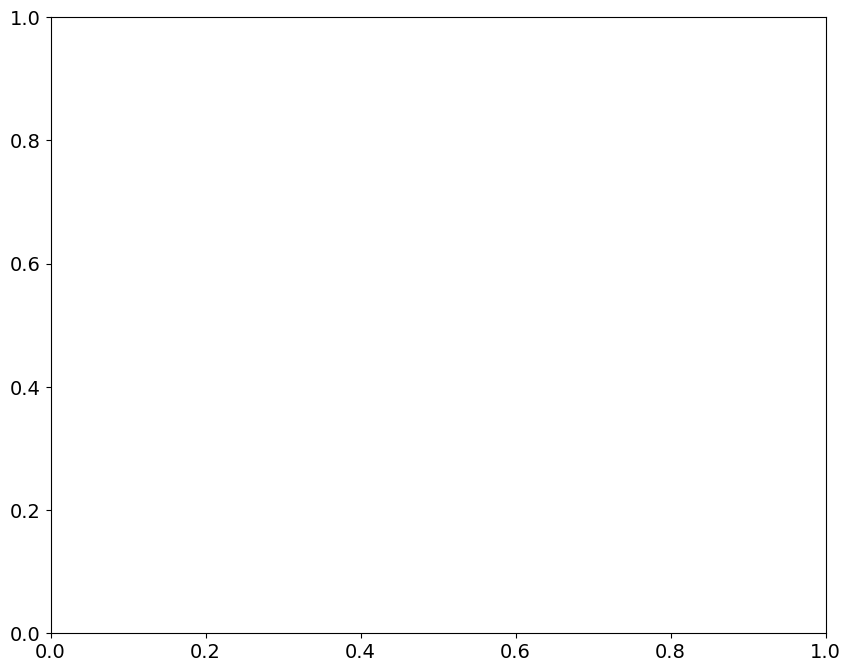

In [49]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.loglog(tau_valid, adev_valid*3600)
ax.set_xlabel("Cluster length (s)")
ax.set_ylabel("Allan deviation (°/h)")
ax.grid(True, which='major')
ax.grid(True, which='minor', axis='y')

Let's extract the properties $N$, $B$ and $K$ automatically:

In [9]:
noise_density, a_n_fit, b_n_fit = allan.read_noise_density(adev_valid, tau_valid)
print("Extracted angle random walk: N = {:.4g} °/s/sqrt(Hz) = {:.5f} °/sqrt(h)"
      .format(noise_density, noise_density*60))
bias_instability = allan.read_bias_instability(adev_valid, tau_valid)
print("Extracted bias instability: B = {:.4g} °/s = {:.5f} °/h"
      .format(bias_instability, bias_instability*3600))
rate_random_walk, a_k_fit, b_k_fit = allan.read_rate_random_walk(adev_valid, tau_valid)
print("Extracted rate random walk: K = {:.4g} °/s^(3/2) = {:.5f} °/h^(3/2)"
      .format(rate_random_walk, rate_random_walk*3600**(3/2)))

Extracted angle random walk: N = 0.005027 °/s/sqrt(Hz) = 0.30159 °/sqrt(h)
Extracted bias instability: B = 0.0007754 °/s = 2.79154 °/h
Extracted rate random walk: K = 6.792e-06 °/s^(3/2) = 1.46705 °/h^(3/2)


If you rather prefer to find these values manually, you can read off the value of the red line at $\tau = 1$ to get $N$. The value of the green line at $\tau = 3$ is equal to $K$, and multiplication of the global minimum by $\sqrt{\frac{\pi}{2\ln 2}}\approx1/0.664$ yields $B$.

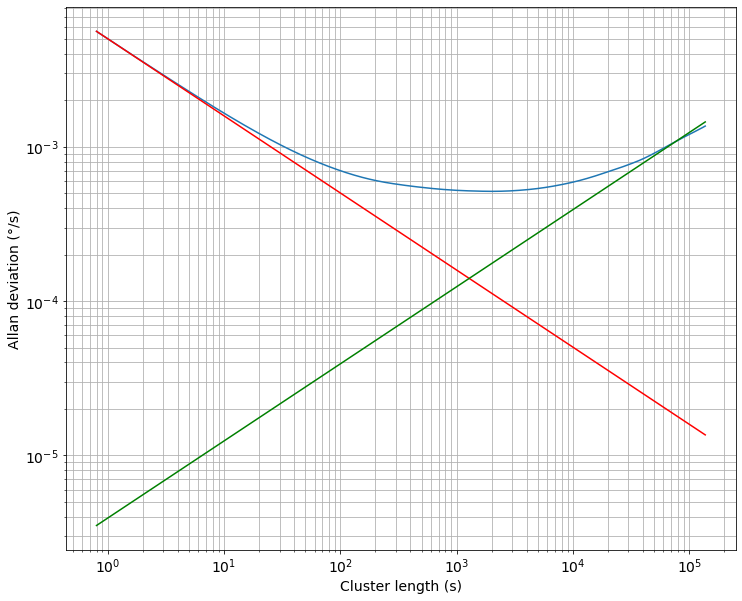

In [16]:
fit_vals_n = np.power(10.0, a_n_fit * np.log10(tau_valid) + b_n_fit)
fit_vals_k = np.power(10.0, a_k_fit * np.log10(tau_valid) + b_k_fit)
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
ax.loglog(tau_valid, adev_valid)
ax.loglog(tau_valid, fit_vals_n, color='red')
ax.loglog(tau_valid, fit_vals_k, color='green')
ax.set_xlabel("Cluster length (s)")
ax.set_ylabel("Allan deviation (°/s)")
ax.grid(True, which='both')